## ___Chest Cancer Detection___

In [1]:
## !pip install -r  requirements.txt


In [1]:
import os
import cv2
import random

import torch 
from torch import nn 
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchsummary import summary

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from tqdm import tqdm

import create_csv as cs
import utils 
import create_dataset as cd
import create_model as model
import train as t
import test

# Clear CUDA cache
torch.cuda.empty_cache()

# Set the seed for the random number generator in PyTorch
torch.manual_seed(42)

## GPU details

In [2]:
# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# Get number of CPU cores
num_cpu_cores = os.cpu_count()
print(f"Number of CPU cores: {num_cpu_cores}")

# Get GPU name
if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    print(f"GPU name: {gpu_name}")
else:
    print("No GPU available")

Device: cuda
Number of CPU cores: 8
GPU name: NVIDIA RTX A6000


## Setup Configurations

In [3]:
# Specifies the path to images
TRAIN_IMAGE = './Data/train/'
TEST_IMAGE = './Data/test/'
VALID_IMAGE = './Data/valid/'

# Specifies the path to the CSV file containing the data
TRAIN_PATH = os.path.join(os.getcwd(),'Dataframe/train.csv')
TEST_PATH = os.path.join(os.getcwd(),'Dataframe/test.csv')
VALID_PATH = os.path.join(os.getcwd(),'Dataframe/valid.csv')

# Set up row and column number 
NUM_IMAGES = 5

# Specifies the batch size 
BATCH_SIZE = 16 

# Specifies the number of classes
NUM_CLASSES = 4


# Specifies loss function
LOSS_FUNCTION = nn.CrossEntropyLoss()

# Specifies the number of training epochs
EPOCHS = 100

### Create dataframe to store the images path and the Label

In [5]:
# cs.create_dataframe(TRAIN_IMAGE)

# cs.create_dataframe(TEST_IMAGE)

# cs.create_dataframe(VALID_IMAGE)

In [4]:
# Read the CSV file into a DataFrame using the specified file path
train_df = pd.read_csv(TRAIN_PATH)
test_df = pd.read_csv(TEST_PATH)
val_df = pd.read_csv(VALID_PATH)

# Display the first few rows of the DataFrame
train_df.head()

,image_path,label
0,./Data/train/Large cell carcinoma/000062 (3).png,Large cell carcinoma
1,./Data/train/Large cell carcinoma/000089.png,Large cell carcinoma
2,./Data/train/Large cell carcinoma/000098 (4).png,Large cell carcinoma
3,./Data/train/Large cell carcinoma/000019 (4).png,Large cell carcinoma
4,./Data/train/Large cell carcinoma/000072 (2).png,Large cell carcinoma


###  Show Distribution of labels in each dataframe

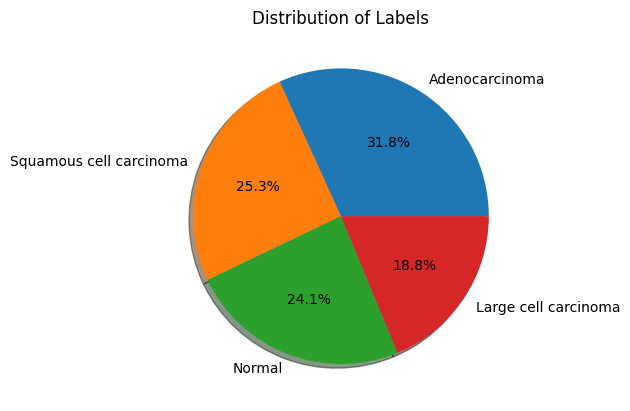

In [7]:
# train
utils.show_labels_distribution(train_df)

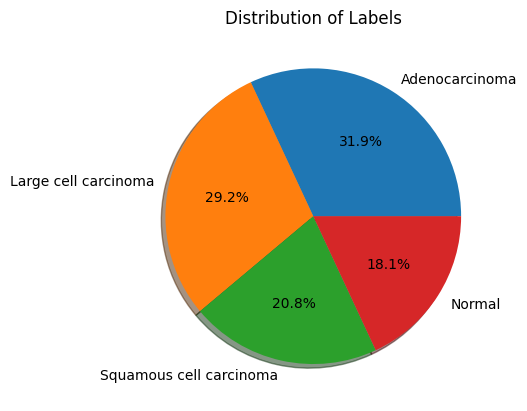

In [8]:
# val
utils.show_labels_distribution(val_df)

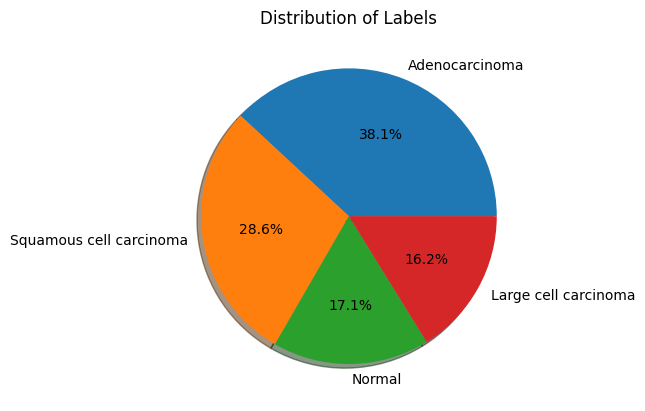

In [9]:
# test
utils.show_labels_distribution(test_df)

## Create Custom Dataset

In [5]:
# load the datasets
trainset = cd.ChestXRay(train_df,augmentations=cd.get_train_augs())
validset = cd.ChestXRay(val_df,augmentations=cd.get_valid_augs())
testset = cd.ChestXRay(test_df,augmentations=cd.get_valid_augs())

In [6]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")
print(f"Size of Testset : {len(testset)}")

Size of Trainset : 613
Size of Validset : 72
Size of Testset : 315


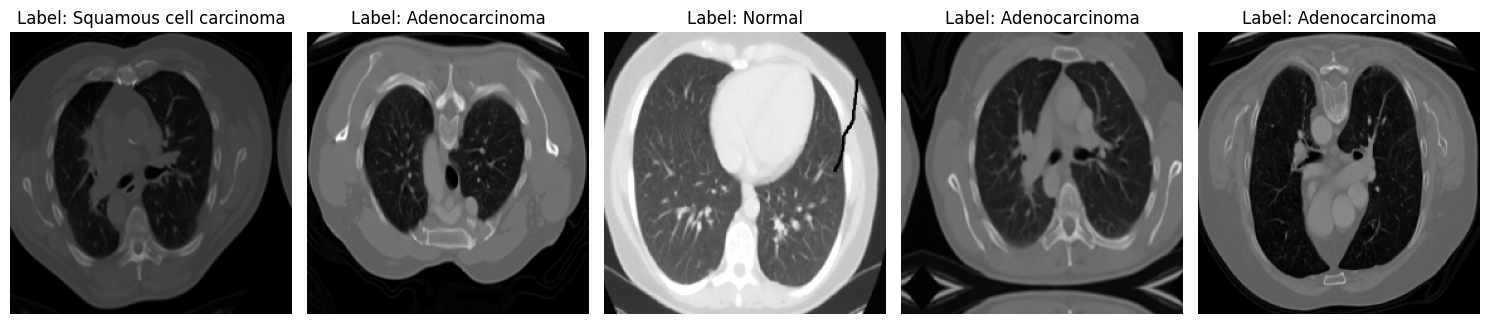

In [7]:
# show some images
utils.show_multiple_images(trainset, NUM_IMAGES)

## Dealing with imbalanced dataset

In [8]:
# initlize sampler
train_sampler = cd.create_weighted_sampler(trainset)

100%|██████████| 613/613 [00:08<00:00, 68.67it/s] 


In [9]:
# Create a data loader for the datasets
train_loader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,sampler=train_sampler,num_workers=4)
val_loader = torch.utils.data.DataLoader(validset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

In [15]:
print(f"total no. of batches in trainloader : {len(train_loader)}")
print(f"total no. of batches in validloader : {len(val_loader)}")
print(f"total no. of batches in testloader : {len(test_loader)}")

total no. of batches in trainloader : 39
total no. of batches in validloader : 5
total no. of batches in testloader : 20


In [16]:
for image , _ in train_loader:
    print(f"One batch image shape : {image.shape}")
    break

One batch image shape : torch.Size([16, 224, 224, 3])


### Create Classification Model

In [10]:
efficientnet_model = model.CustomModel(NUM_CLASSES)

Loaded pretrained weights for efficientnet-b5


In [11]:
summary(efficientnet_model.to(device),input_size=(224,224,3))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         ZeroPad2d-1          [-1, 3, 225, 225]               0
Conv2dStaticSamePadding-2         [-1, 48, 112, 112]           1,296
       BatchNorm2d-3         [-1, 48, 112, 112]              96
MemoryEfficientSwish-4         [-1, 48, 112, 112]               0
         ZeroPad2d-5         [-1, 48, 114, 114]               0
Conv2dStaticSamePadding-6         [-1, 48, 112, 112]             432
       BatchNorm2d-7         [-1, 48, 112, 112]              96
MemoryEfficientSwish-8         [-1, 48, 112, 112]               0
          Identity-9             [-1, 48, 1, 1]               0
Conv2dStaticSamePadding-10             [-1, 12, 1, 1]             588
MemoryEfficientSwish-11             [-1, 12, 1, 1]               0
         Identity-12             [-1, 12, 1, 1]               0
Conv2dStaticSamePadding-13             [-1, 48, 1, 1]             624
         I

### Train and evaluate the model

100%|██████████| 5/5 [00:00<00:00,  8.04it/s]


SAVED-MODEL
Epoch: 1 Train loss: 1.0949 Train accuracy: 0.5721 Valid loss: 1.7238 Valid accuracy: 0.4375


100%|██████████| 5/5 [00:00<00:00,  8.76it/s]


Epoch: 2 Train loss: 0.8032 Train accuracy: 0.6747 Valid loss: 3.6915 Valid accuracy: 0.2875


100%|██████████| 5/5 [00:00<00:00,  8.62it/s]


Epoch: 3 Train loss: 0.7086 Train accuracy: 0.7772 Valid loss: 1.8899 Valid accuracy: 0.5125


100%|██████████| 5/5 [00:00<00:00,  8.59it/s]


Epoch: 4 Train loss: 0.5333 Train accuracy: 0.8199 Valid loss: 3.8058 Valid accuracy: 0.4625


100%|██████████| 5/5 [00:00<00:00,  8.31it/s]


SAVED-MODEL
Epoch: 5 Train loss: 0.7227 Train accuracy: 0.7436 Valid loss: 1.5300 Valid accuracy: 0.5500


100%|██████████| 5/5 [00:00<00:00,  8.25it/s]


Epoch: 6 Train loss: 0.3192 Train accuracy: 0.8974 Valid loss: 2.3545 Valid accuracy: 0.5875


100%|██████████| 5/5 [00:00<00:00,  8.84it/s]


Epoch: 7 Train loss: 0.5637 Train accuracy: 0.8106 Valid loss: 3.7046 Valid accuracy: 0.5500


100%|██████████| 5/5 [00:00<00:00,  8.51it/s]


Epoch: 8 Train loss: 0.4172 Train accuracy: 0.8654 Valid loss: 3.1299 Valid accuracy: 0.4125


100%|██████████| 5/5 [00:00<00:00,  8.34it/s]


SAVED-MODEL
Epoch: 9 Train loss: 0.3446 Train accuracy: 0.8808 Valid loss: 0.8508 Valid accuracy: 0.7750


100%|██████████| 5/5 [00:00<00:00,  8.13it/s]


Epoch: 10 Train loss: 0.2969 Train accuracy: 0.9103 Valid loss: 1.8257 Valid accuracy: 0.4750


100%|██████████| 5/5 [00:00<00:00,  8.45it/s]


Epoch: 11 Train loss: 0.2538 Train accuracy: 0.9103 Valid loss: 1.4797 Valid accuracy: 0.6625


100%|██████████| 5/5 [00:00<00:00,  8.32it/s]


Epoch: 12 Train loss: 0.4473 Train accuracy: 0.8776 Valid loss: 0.9818 Valid accuracy: 0.6250


100%|██████████| 5/5 [00:00<00:00,  8.20it/s]


SAVED-MODEL
Epoch: 13 Train loss: 0.4984 Train accuracy: 0.8574 Valid loss: 0.7353 Valid accuracy: 0.8125


100%|██████████| 5/5 [00:00<00:00,  8.48it/s]


SAVED-MODEL
Epoch: 14 Train loss: 0.1929 Train accuracy: 0.9516 Valid loss: 0.5697 Valid accuracy: 0.8375


100%|██████████| 5/5 [00:00<00:00,  8.42it/s]


SAVED-MODEL
Epoch: 15 Train loss: 0.4621 Train accuracy: 0.8750 Valid loss: 0.5042 Valid accuracy: 0.8750


100%|██████████| 5/5 [00:00<00:00,  8.11it/s]


Epoch: 16 Train loss: 0.3325 Train accuracy: 0.9138 Valid loss: 0.5243 Valid accuracy: 0.8625


100%|██████████| 5/5 [00:00<00:00,  8.58it/s]


SAVED-MODEL
Epoch: 17 Train loss: 0.2419 Train accuracy: 0.9208 Valid loss: 0.2947 Valid accuracy: 0.9375


100%|██████████| 5/5 [00:00<00:00,  8.73it/s]


Epoch: 18 Train loss: 0.5874 Train accuracy: 0.8397 Valid loss: 1.1549 Valid accuracy: 0.8000


100%|██████████| 5/5 [00:00<00:00,  8.00it/s]


Epoch: 19 Train loss: 0.2725 Train accuracy: 0.9234 Valid loss: 0.8262 Valid accuracy: 0.7750


100%|██████████| 5/5 [00:00<00:00,  8.37it/s]


Epoch: 20 Train loss: 0.4233 Train accuracy: 0.8814 Valid loss: 0.2956 Valid accuracy: 0.9000


100%|██████████| 5/5 [00:00<00:00,  7.90it/s]


Epoch: 21 Train loss: 0.1762 Train accuracy: 0.9494 Valid loss: 0.9473 Valid accuracy: 0.7000


100%|██████████| 5/5 [00:00<00:00,  8.18it/s]


Epoch: 22 Train loss: 0.2641 Train accuracy: 0.9045 Valid loss: 0.6646 Valid accuracy: 0.7875


100%|██████████| 5/5 [00:00<00:00,  7.87it/s]


Epoch: 23 Train loss: 0.1492 Train accuracy: 0.9583 Valid loss: 0.3551 Valid accuracy: 0.8750
Epoch 00023: reducing learning rate of group 0 to 1.0000e-04.


100%|██████████| 5/5 [00:00<00:00,  7.94it/s]


Epoch: 24 Train loss: 0.1035 Train accuracy: 0.9712 Valid loss: 0.3712 Valid accuracy: 0.8625


100%|██████████| 5/5 [00:00<00:00,  8.10it/s]


Epoch: 25 Train loss: 0.2204 Train accuracy: 0.9401 Valid loss: 0.3080 Valid accuracy: 0.9000


100%|██████████| 5/5 [00:00<00:00,  8.64it/s]


SAVED-MODEL
Epoch: 26 Train loss: 0.2049 Train accuracy: 0.9413 Valid loss: 0.1876 Valid accuracy: 0.9375


100%|██████████| 5/5 [00:00<00:00,  8.44it/s]


Epoch: 27 Train loss: 0.0535 Train accuracy: 0.9872 Valid loss: 0.2708 Valid accuracy: 0.9125


100%|██████████| 5/5 [00:00<00:00,  8.10it/s]


Epoch: 28 Train loss: 0.3839 Train accuracy: 0.9003 Valid loss: 0.6939 Valid accuracy: 0.8125


100%|██████████| 5/5 [00:00<00:00,  7.85it/s]


Epoch: 29 Train loss: 0.1328 Train accuracy: 0.9647 Valid loss: 0.3389 Valid accuracy: 0.9000


100%|██████████| 5/5 [00:00<00:00,  8.36it/s]


SAVED-MODEL
Epoch: 30 Train loss: 0.1876 Train accuracy: 0.9487 Valid loss: 0.1813 Valid accuracy: 0.9500


100%|██████████| 5/5 [00:00<00:00,  8.34it/s]


Epoch: 31 Train loss: 0.0628 Train accuracy: 0.9872 Valid loss: 0.9695 Valid accuracy: 0.7875


100%|██████████| 5/5 [00:00<00:00,  8.76it/s]


Epoch: 32 Train loss: 0.1395 Train accuracy: 0.9631 Valid loss: 0.3209 Valid accuracy: 0.9125


100%|██████████| 5/5 [00:00<00:00,  7.94it/s]


Epoch: 33 Train loss: 0.0647 Train accuracy: 0.9856 Valid loss: 0.2448 Valid accuracy: 0.9500


100%|██████████| 5/5 [00:00<00:00,  8.31it/s]


Epoch: 34 Train loss: 0.0390 Train accuracy: 0.9936 Valid loss: 0.1932 Valid accuracy: 0.9625


100%|██████████| 5/5 [00:00<00:00,  8.03it/s]


Epoch: 35 Train loss: 0.0565 Train accuracy: 0.9808 Valid loss: 0.2335 Valid accuracy: 0.9500


100%|██████████| 5/5 [00:00<00:00,  8.08it/s]


Epoch: 36 Train loss: 0.1611 Train accuracy: 0.9583 Valid loss: 0.6732 Valid accuracy: 0.8750
Epoch 00036: reducing learning rate of group 0 to 1.0000e-05.


100%|██████████| 5/5 [00:00<00:00,  8.02it/s]


Epoch: 37 Train loss: 0.1889 Train accuracy: 0.9519 Valid loss: 0.2041 Valid accuracy: 0.9500


100%|██████████| 5/5 [00:00<00:00,  7.99it/s]


Epoch: 38 Train loss: 0.1929 Train accuracy: 0.9484 Valid loss: 0.2730 Valid accuracy: 0.9500


100%|██████████| 5/5 [00:00<00:00,  8.42it/s]


Epoch: 39 Train loss: 0.1244 Train accuracy: 0.9631 Valid loss: 0.2128 Valid accuracy: 0.9625


100%|██████████| 5/5 [00:00<00:00,  8.49it/s]


Epoch: 40 Train loss: 0.1082 Train accuracy: 0.9619 Valid loss: 0.2074 Valid accuracy: 0.9625


100%|██████████| 5/5 [00:00<00:00,  8.10it/s]


Epoch: 41 Train loss: 0.2003 Train accuracy: 0.9471 Valid loss: 0.2075 Valid accuracy: 0.9625


100%|██████████| 5/5 [00:00<00:00,  8.57it/s]


Epoch: 42 Train loss: 0.1461 Train accuracy: 0.9606 Valid loss: 0.4010 Valid accuracy: 0.9125
Epoch 00042: reducing learning rate of group 0 to 1.0000e-06.


100%|██████████| 5/5 [00:00<00:00,  8.11it/s]


Epoch: 43 Train loss: 0.0865 Train accuracy: 0.9801 Valid loss: 0.1959 Valid accuracy: 0.9625


100%|██████████| 5/5 [00:00<00:00,  8.26it/s]


Epoch: 44 Train loss: 0.1393 Train accuracy: 0.9612 Valid loss: 0.5711 Valid accuracy: 0.8625


100%|██████████| 5/5 [00:00<00:00,  7.77it/s]


Epoch: 45 Train loss: 0.0411 Train accuracy: 0.9901 Valid loss: 0.1966 Valid accuracy: 0.9625


100%|██████████| 5/5 [00:00<00:00,  8.57it/s]


Epoch: 46 Train loss: 0.1524 Train accuracy: 0.9696 Valid loss: 0.1905 Valid accuracy: 0.9625


100%|██████████| 5/5 [00:00<00:00,  8.72it/s]


Epoch: 47 Train loss: 0.1565 Train accuracy: 0.9606 Valid loss: 0.6098 Valid accuracy: 0.8625


100%|██████████| 5/5 [00:00<00:00,  7.89it/s]


Epoch: 48 Train loss: 0.1293 Train accuracy: 0.9715 Valid loss: 0.2019 Valid accuracy: 0.9625
Epoch 00048: reducing learning rate of group 0 to 1.0000e-07.


100%|██████████| 5/5 [00:00<00:00,  8.25it/s]


Epoch: 49 Train loss: 0.1267 Train accuracy: 0.9731 Valid loss: 0.2083 Valid accuracy: 0.9625


100%|██████████| 5/5 [00:00<00:00,  8.54it/s]


Epoch: 50 Train loss: 0.2074 Train accuracy: 0.9458 Valid loss: 0.1986 Valid accuracy: 0.9625


100%|██████████| 5/5 [00:00<00:00,  7.95it/s]


Epoch: 51 Train loss: 0.1743 Train accuracy: 0.9558 Valid loss: 0.1990 Valid accuracy: 0.9625


100%|██████████| 5/5 [00:00<00:00,  7.92it/s]


Epoch: 52 Train loss: 0.1131 Train accuracy: 0.9728 Valid loss: 0.4865 Valid accuracy: 0.8875


100%|██████████| 5/5 [00:00<00:00,  8.00it/s]


Epoch: 53 Train loss: 0.0751 Train accuracy: 0.9821 Valid loss: 0.2195 Valid accuracy: 0.9500


100%|██████████| 5/5 [00:00<00:00,  8.32it/s]


Epoch: 54 Train loss: 0.1056 Train accuracy: 0.9663 Valid loss: 0.1883 Valid accuracy: 0.9625
Epoch 00054: reducing learning rate of group 0 to 1.0000e-08.


100%|██████████| 5/5 [00:00<00:00,  8.37it/s]


Epoch: 55 Train loss: 0.1186 Train accuracy: 0.9712 Valid loss: 0.1903 Valid accuracy: 0.9625


100%|██████████| 5/5 [00:00<00:00,  8.52it/s]


Epoch: 56 Train loss: 0.2962 Train accuracy: 0.9266 Valid loss: 0.4730 Valid accuracy: 0.8875


100%|██████████| 5/5 [00:00<00:00,  8.16it/s]


Epoch: 57 Train loss: 0.1207 Train accuracy: 0.9679 Valid loss: 1.1433 Valid accuracy: 0.7625


100%|██████████| 5/5 [00:00<00:00,  8.07it/s]


Epoch: 58 Train loss: 0.1334 Train accuracy: 0.9564 Valid loss: 0.6732 Valid accuracy: 0.8375


100%|██████████| 5/5 [00:00<00:00,  7.84it/s]


Epoch: 59 Train loss: 0.1367 Train accuracy: 0.9628 Valid loss: 0.3630 Valid accuracy: 0.9125


100%|██████████| 5/5 [00:00<00:00,  8.36it/s]


Epoch: 60 Train loss: 0.0372 Train accuracy: 0.9936 Valid loss: 0.2083 Valid accuracy: 0.9625


100%|██████████| 5/5 [00:00<00:00,  8.42it/s]


Epoch: 61 Train loss: 0.2392 Train accuracy: 0.9426 Valid loss: 0.3083 Valid accuracy: 0.9375


100%|██████████| 5/5 [00:00<00:00,  8.15it/s]


Epoch: 62 Train loss: 0.0461 Train accuracy: 0.9856 Valid loss: 0.2377 Valid accuracy: 0.9500


100%|██████████| 5/5 [00:00<00:00,  8.61it/s]


Epoch: 63 Train loss: 0.0554 Train accuracy: 0.9936 Valid loss: 0.8656 Valid accuracy: 0.7875


100%|██████████| 5/5 [00:00<00:00,  8.29it/s]


Epoch: 64 Train loss: 0.1348 Train accuracy: 0.9647 Valid loss: 0.3095 Valid accuracy: 0.9375


100%|██████████| 5/5 [00:00<00:00,  8.00it/s]


Epoch: 65 Train loss: 0.1397 Train accuracy: 0.9561 Valid loss: 0.1995 Valid accuracy: 0.9625


100%|██████████| 5/5 [00:00<00:00,  8.25it/s]


Epoch: 66 Train loss: 0.2204 Train accuracy: 0.9413 Valid loss: 0.1939 Valid accuracy: 0.9625


100%|██████████| 5/5 [00:00<00:00,  8.22it/s]


Epoch: 67 Train loss: 0.1996 Train accuracy: 0.9455 Valid loss: 0.1943 Valid accuracy: 0.9625


100%|██████████| 5/5 [00:00<00:00,  8.49it/s]


Epoch: 68 Train loss: 0.2409 Train accuracy: 0.9327 Valid loss: 0.2668 Valid accuracy: 0.9500


100%|██████████| 5/5 [00:00<00:00,  8.15it/s]


Epoch: 69 Train loss: 0.0286 Train accuracy: 0.9968 Valid loss: 0.2127 Valid accuracy: 0.9625


100%|██████████| 5/5 [00:00<00:00,  8.23it/s]


Epoch: 70 Train loss: 0.1093 Train accuracy: 0.9728 Valid loss: 0.1997 Valid accuracy: 0.9625


100%|██████████| 5/5 [00:00<00:00,  8.57it/s]


Epoch: 71 Train loss: 0.1872 Train accuracy: 0.9506 Valid loss: 0.1942 Valid accuracy: 0.9625


100%|██████████| 5/5 [00:00<00:00,  8.26it/s]


Epoch: 72 Train loss: 0.0982 Train accuracy: 0.9744 Valid loss: 0.8618 Valid accuracy: 0.8125


100%|██████████| 5/5 [00:00<00:00,  8.21it/s]


Epoch: 73 Train loss: 0.0505 Train accuracy: 0.9837 Valid loss: 0.1934 Valid accuracy: 0.9625


100%|██████████| 5/5 [00:00<00:00,  7.55it/s]


Epoch: 74 Train loss: 0.1187 Train accuracy: 0.9731 Valid loss: 0.2898 Valid accuracy: 0.9375


100%|██████████| 5/5 [00:00<00:00,  7.25it/s]


Epoch: 75 Train loss: 0.0403 Train accuracy: 0.9949 Valid loss: 0.1915 Valid accuracy: 0.9625


100%|██████████| 5/5 [00:00<00:00,  7.72it/s]


Epoch: 76 Train loss: 0.1883 Train accuracy: 0.9503 Valid loss: 0.5550 Valid accuracy: 0.8875


100%|██████████| 5/5 [00:00<00:00,  7.87it/s]


Epoch: 77 Train loss: 0.2102 Train accuracy: 0.9330 Valid loss: 0.6063 Valid accuracy: 0.8500


100%|██████████| 5/5 [00:00<00:00,  8.09it/s]


Epoch: 78 Train loss: 0.1822 Train accuracy: 0.9503 Valid loss: 1.1145 Valid accuracy: 0.7625


100%|██████████| 5/5 [00:00<00:00,  7.35it/s]


Epoch: 79 Train loss: 0.1098 Train accuracy: 0.9696 Valid loss: 0.5886 Valid accuracy: 0.8625


100%|██████████| 5/5 [00:00<00:00,  7.91it/s]


Epoch: 80 Train loss: 0.2150 Train accuracy: 0.9423 Valid loss: 0.2058 Valid accuracy: 0.9625


100%|██████████| 5/5 [00:00<00:00,  8.31it/s]


Epoch: 81 Train loss: 0.1215 Train accuracy: 0.9696 Valid loss: 0.2081 Valid accuracy: 0.9625


100%|██████████| 5/5 [00:00<00:00,  8.36it/s]


Epoch: 82 Train loss: 0.0488 Train accuracy: 0.9817 Valid loss: 0.3290 Valid accuracy: 0.9250


100%|██████████| 5/5 [00:00<00:00,  8.32it/s]


Epoch: 83 Train loss: 0.1064 Train accuracy: 0.9740 Valid loss: 0.2002 Valid accuracy: 0.9625


100%|██████████| 5/5 [00:00<00:00,  8.24it/s]


Epoch: 84 Train loss: 0.0527 Train accuracy: 0.9888 Valid loss: 0.4369 Valid accuracy: 0.9000


100%|██████████| 5/5 [00:00<00:00,  8.55it/s]


Epoch: 85 Train loss: 0.1455 Train accuracy: 0.9663 Valid loss: 0.2596 Valid accuracy: 0.9500


100%|██████████| 5/5 [00:00<00:00,  8.41it/s]


Epoch: 86 Train loss: 0.3308 Train accuracy: 0.9151 Valid loss: 0.2383 Valid accuracy: 0.9500


100%|██████████| 5/5 [00:00<00:00,  8.23it/s]


Epoch: 87 Train loss: 0.2825 Train accuracy: 0.9087 Valid loss: 0.1897 Valid accuracy: 0.9625


100%|██████████| 5/5 [00:00<00:00,  8.35it/s]


Epoch: 88 Train loss: 0.0587 Train accuracy: 0.9801 Valid loss: 0.4228 Valid accuracy: 0.9125


100%|██████████| 5/5 [00:00<00:00,  7.98it/s]


Epoch: 89 Train loss: 0.0513 Train accuracy: 0.9936 Valid loss: 0.6617 Valid accuracy: 0.8375


100%|██████████| 5/5 [00:00<00:00,  8.47it/s]


Epoch: 90 Train loss: 0.0972 Train accuracy: 0.9728 Valid loss: 0.2018 Valid accuracy: 0.9625


100%|██████████| 5/5 [00:00<00:00,  7.98it/s]


Epoch: 91 Train loss: 0.0405 Train accuracy: 0.9888 Valid loss: 0.4065 Valid accuracy: 0.9125


100%|██████████| 5/5 [00:00<00:00,  8.68it/s]


Epoch: 92 Train loss: 0.0492 Train accuracy: 0.9872 Valid loss: 0.4585 Valid accuracy: 0.8875


100%|██████████| 5/5 [00:00<00:00,  8.31it/s]


Epoch: 93 Train loss: 0.0557 Train accuracy: 0.9849 Valid loss: 0.2583 Valid accuracy: 0.9500


100%|██████████| 5/5 [00:00<00:00,  8.21it/s]


Epoch: 94 Train loss: 0.1359 Train accuracy: 0.9615 Valid loss: 0.7158 Valid accuracy: 0.8250


100%|██████████| 5/5 [00:00<00:00,  8.48it/s]


Epoch: 95 Train loss: 0.0990 Train accuracy: 0.9715 Valid loss: 0.1858 Valid accuracy: 0.9625


100%|██████████| 5/5 [00:00<00:00,  8.78it/s]


Epoch: 96 Train loss: 0.0323 Train accuracy: 0.9968 Valid loss: 0.1830 Valid accuracy: 0.9625


100%|██████████| 5/5 [00:00<00:00,  8.63it/s]


Epoch: 97 Train loss: 0.1556 Train accuracy: 0.9577 Valid loss: 0.1895 Valid accuracy: 0.9625


100%|██████████| 5/5 [00:00<00:00,  8.27it/s]


Epoch: 98 Train loss: 0.0290 Train accuracy: 0.9984 Valid loss: 0.1933 Valid accuracy: 0.9625


100%|██████████| 5/5 [00:00<00:00,  8.27it/s]


Epoch: 99 Train loss: 0.0948 Train accuracy: 0.9744 Valid loss: 0.1899 Valid accuracy: 0.9625


100%|██████████| 5/5 [00:00<00:00,  8.23it/s]


Epoch: 100 Train loss: 0.1744 Train accuracy: 0.9542 Valid loss: 0.1896 Valid accuracy: 0.9625
Best Validation Accuracy: 0.9500


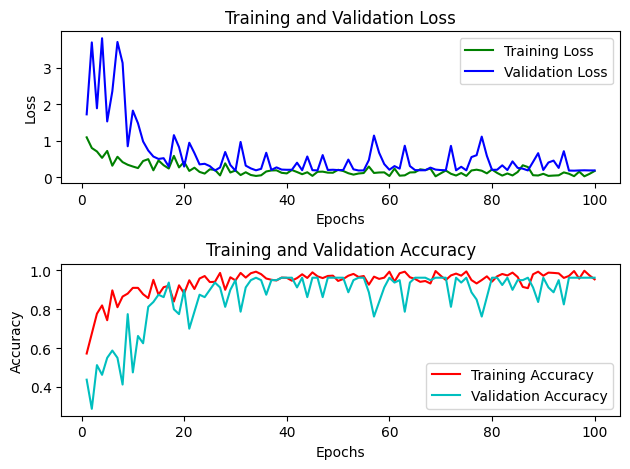

In [19]:
# Specifies optimizer and scheduler 
OPTIMIZER = torch.optim.Adam(efficientnet_model.parameters(), lr=0.001)
SCHEDULER = torch.optim.lr_scheduler.ReduceLROnPlateau(OPTIMIZER, mode='min', factor=0.1, patience=5, verbose=True)

trainer = t.Trainer(efficientnet_model, OPTIMIZER, SCHEDULER, device)
trainer.train_and_evaluate(EPOCHS, train_loader, val_loader, LOSS_FUNCTION)

### Deploy model

In [33]:
# load the saved model
model = efficientnet_model.load_state_dict(torch.load('./best_model.pt'))

In [21]:
# init tester
tester = test.ImageClassifier()

In [22]:
# get the true labels and predected classes 
true_labels, predicted_classes = tester.predict(test_loader, efficientnet_model, device)

In [23]:
# print classification repoert
tester.print_classification_report(true_labels, predicted_classes)

                         precision    recall  f1-score   support

         Adenocarcinoma       0.91      0.93      0.92       120
   Large cell carcinoma       0.89      0.91      0.90        53
                 Normal       0.96      0.91      0.94        56
Squamous cell carcinoma       0.92      0.92      0.92        86

               accuracy                           0.92       315
              macro avg       0.92      0.91      0.92       315
           weighted avg       0.92      0.92      0.92       315



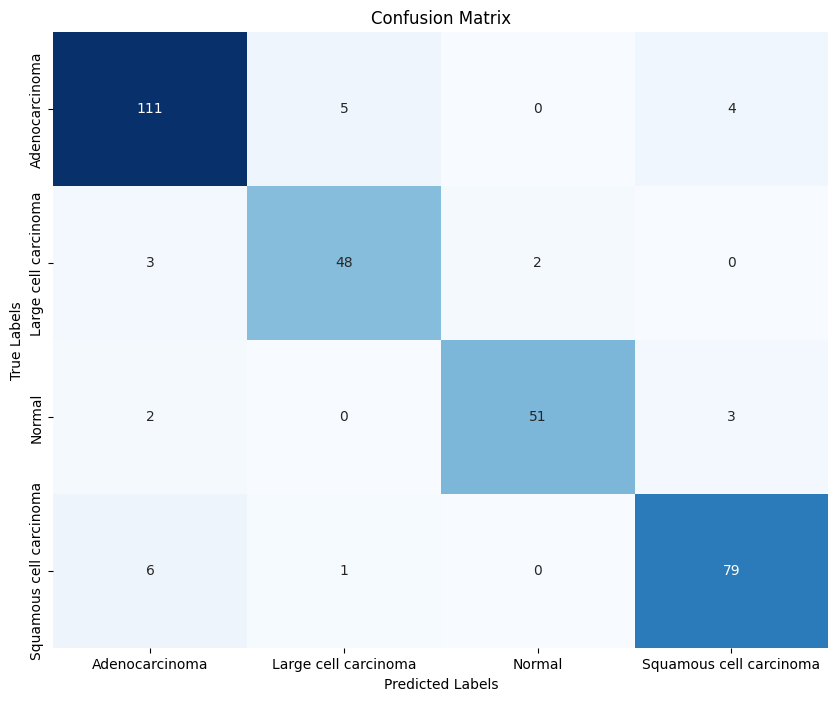

In [24]:
# plot confusion matrix
tester.plot_confusion_matrix(true_labels, predicted_classes)

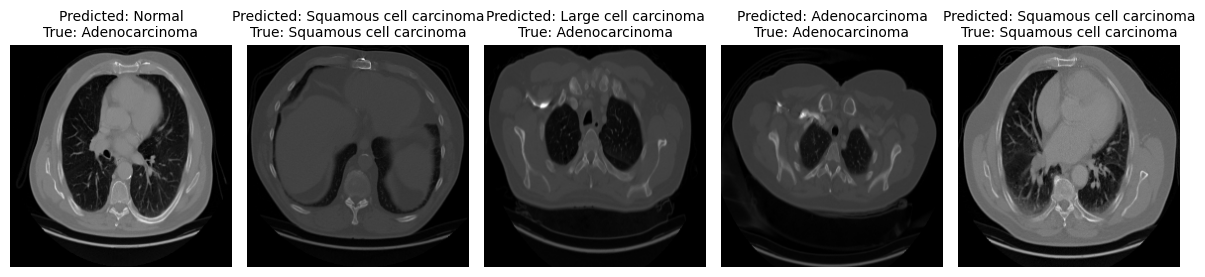

In [27]:
tester.display_predicted_images(test_loader, num_images=5)


In [83]:
staet = torch.load('./best_model.pt')
efficientnet_model.load_state_dict(state)

<All keys matched successfully>